In [1]:
import os, math, random, json, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [12]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(device)

cpu


In [13]:
if not os.path.exists("architecture.py"):
    with open("architecture.py", "w") as f:
        f.write(
            "import torch\n"
            "import torch.nn as nn\n"
            "import torch.nn.functional as F\n"
            "class VAE(nn.Module):\n"
            "    def __init__(self, latent_dim=32):\n"
            "        super().__init__()\n"
            "        self.latent_dim = latent_dim\n"
            "        self.encoder = nn.Sequential(\n"
            "            nn.Conv2d(1, 32, 4, 2, 1),\n"
            "            nn.ReLU(inplace=True),\n"
            "            nn.Conv2d(32, 64, 4, 2, 1),\n"
            "            nn.ReLU(inplace=True),\n"
            "        )\n"
            "        self.enc_fc = nn.Sequential(\n"
            "            nn.Flatten(),\n"
            "            nn.Linear(64 * 7 * 7, 256),\n"
            "            nn.ReLU(inplace=True),\n"
            "        )\n"
            "        self.mu = nn.Linear(256, latent_dim)\n"
            "        self.logvar = nn.Linear(256, latent_dim)\n"
            "        self.dec_fc = nn.Sequential(\n"
            "            nn.Linear(latent_dim, 256),\n"
            "            nn.ReLU(inplace=True),\n"
            "            nn.Linear(256, 64 * 7 * 7),\n"
            "            nn.ReLU(inplace=True),\n"
            "        )\n"
            "        self.decoder = nn.Sequential(\n"
            "            nn.ConvTranspose2d(64, 32, 4, 2, 1),\n"
            "            nn.ReLU(inplace=True),\n"
            "            nn.ConvTranspose2d(32, 1, 4, 2, 1),\n"
            "            nn.Sigmoid(),\n"
            "        )\n"
            "    def encode(self, x):\n"
            "        h = self.encoder(x)\n"
            "        h = self.enc_fc(h)\n"
            "        return self.mu(h), self.logvar(h)\n"
            "    def reparameterize(self, mu, logvar):\n"
            "        std = torch.exp(0.5 * logvar)\n"
            "        eps = torch.randn_like(std)\n"
            "        return mu + eps * std\n"
            "    def decode(self, z):\n"
            "        h = self.dec_fc(z)\n"
            "        h = h.view(z.size(0), 64, 7, 7)\n"
            "        return self.decoder(h)\n"
            "    def forward(self, x):\n"
            "        mu, logvar = self.encode(x)\n"
            "        z = self.reparameterize(mu, logvar)\n"
            "        xhat = self.decode(z)\n"
            "        return xhat, mu, logvar\n"
        )

In [17]:
from architecture import VAE
batch_size = 256
epochs_baseline = 10
epochs_mitigated = 10
latent_dim = 32
lr = 2e-3
enc_lr_mult_mitigated = 2.0
warmup_steps = 3000
kl_beta_target = 1.0

In [18]:
transform = transforms.ToTensor()

train_full = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

In [19]:
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

def vae_losses(xhat, x, mu, logvar):
    recon = F.mse_loss(xhat, x, reduction="none").view(x.size(0), -1).sum(dim=1)
    kl = kl_divergence(mu, logvar)
    return recon, kl

In [20]:
def show_grid(x, title="", nrow=8):
    grid = make_grid(x.cpu(), nrow=nrow)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0)[:,:,0], cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [21]:
@torch.no_grad()
def analyze_posterior(model, loader, max_batches=20):
    model.eval()
    mu_abs, std_mean, kl_mean = [], [], []
    for i, (x, _) in enumerate(loader):
        if i >= max_batches:
            break
        x = x.to(device)
        xhat, mu, logvar = model(x)
        _, kl = vae_losses(xhat, x, mu, logvar)
        mu_abs.append(mu.abs().mean().item())
        std_mean.append(torch.exp(0.5 * logvar).mean().item())
        kl_mean.append(kl.mean().item())
    return np.mean(mu_abs), np.mean(std_mean), np.mean(kl_mean)

In [22]:
def run_experiment(name, epochs, anneal=False, enc_lr_mult=1.0):
    model = VAE(latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"recon": [], "kl": []}
    step = 0

    for epoch in range(epochs):
        model.train()
        for x, _ in train_loader:
            x = x.to(device)
            xhat, mu, logvar = model(x)
            recon, kl = vae_losses(xhat, x, mu, logvar)
            beta = min(1.0, step / warmup_steps) if anneal else 1.0
            loss = (recon + beta * kl).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step += 1
        history["recon"].append(recon.mean().item())
        history["kl"].append(kl.mean().item())
        print(name, epoch, history["recon"][-1], history["kl"][-1])

    return model, history

In [23]:
def run_experiment(name, epochs, anneal=False, enc_lr_mult=1.0):
    model = VAE(latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"recon": [], "kl": []}
    step = 0

    for epoch in range(epochs):
        model.train()
        for x, _ in train_loader:
            x = x.to(device)
            xhat, mu, logvar = model(x)
            recon, kl = vae_losses(xhat, x, mu, logvar)
            beta = min(1.0, step / warmup_steps) if anneal else 1.0
            loss = (recon + beta * kl).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step += 1
        history["recon"].append(recon.mean().item())
        history["kl"].append(kl.mean().item())
        print(name, epoch, history["recon"][-1], history["kl"][-1])

    return model, history

In [24]:
baseline_model, baseline_hist = run_experiment("baseline", epochs_baseline, anneal=False)
mitigated_model, mitigated_hist = run_experiment("mitigated", epochs_mitigated, anneal=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


baseline 0 28.105321884155273 6.401510238647461
baseline 1 23.614099502563477 6.3956074714660645
baseline 2 22.35285186767578 6.163963317871094
baseline 3 20.854408264160156 6.161029815673828
baseline 4 20.42021369934082 6.4893927574157715
baseline 5 19.640506744384766 6.885178089141846
baseline 6 19.126888275146484 6.29536247253418
baseline 7 19.684551239013672 6.347393035888672
baseline 8 18.819196701049805 6.750849723815918
baseline 9 18.579517364501953 6.675929069519043
mitigated 0 17.242021560668945 33.511348724365234
mitigated 1 15.447311401367188 23.652090072631836
mitigated 2 13.232598304748535 19.747331619262695
mitigated 3 12.955684661865234 15.821796417236328
mitigated 4 13.928967475891113 15.51895523071289
mitigated 5 13.884967803955078 13.263517379760742
mitigated 6 13.36502456665039 12.433919906616211
mitigated 7 13.700345039367676 11.82828140258789
mitigated 8 13.769634246826172 11.672042846679688
mitigated 9 14.460585594177246 10.532804489135742


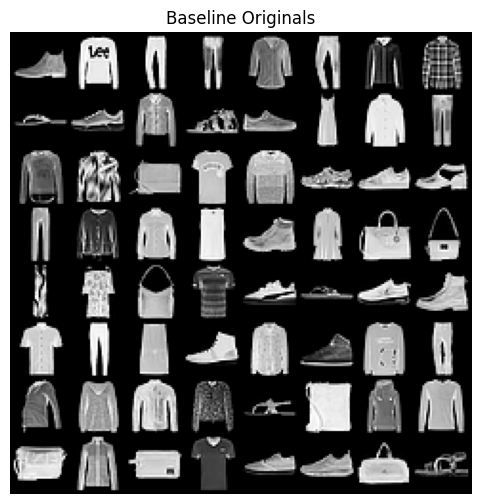

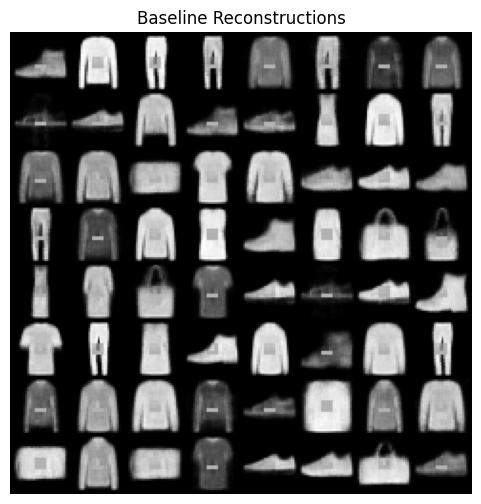

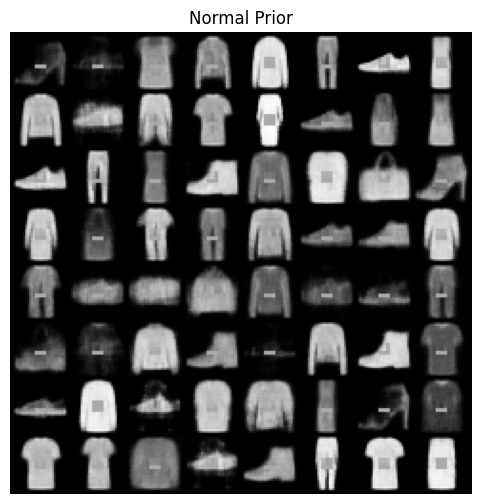

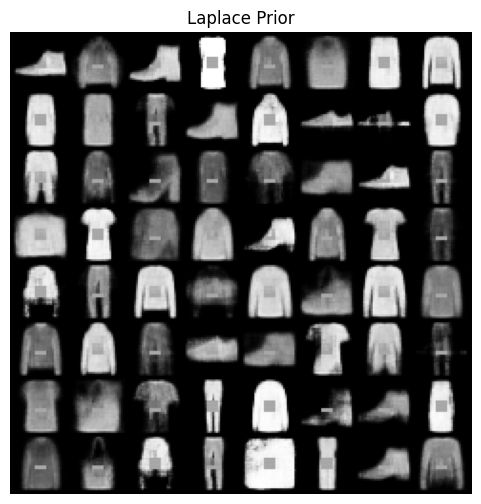

In [25]:
x, _ = next(iter(test_loader))
x = x[:64].to(device)

with torch.no_grad():
    xhat, _, _ = baseline_model(x)
    show_grid(x, "Baseline Originals")
    show_grid(xhat, "Baseline Reconstructions")

with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    show_grid(baseline_model.decode(z), "Normal Prior")

    lap = torch.distributions.Laplace(0, 1)
    z = lap.sample((64, latent_dim)).to(device)
    show_grid(baseline_model.decode(z), "Laplace Prior")